<a href="https://colab.research.google.com/github/bharatadhik/jupyternotebooks/blob/main/july_17_clean_semantic_similarity_with_bert_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semantic Similarity with BERT

**Author:** [Mohamad Merchant](https://twitter.com/mohmadmerchant1)<br>
**Date created:** 2020/08/15<br>
**Last modified:** 2020/08/29<br>
**Description:** Natural Language Inference by fine-tuning BERT model on SNLI Corpus.

## Introduction

Semantic Similarity is the task of determining how similar
two sentences are, in terms of what they mean.
This example demonstrates the use of SNLI (Stanford Natural Language Inference) Corpus
to predict sentence semantic similarity with Transformers.
We will fine-tune a BERT model that takes two sentences as inputs
and that outputs a similarity score for these two sentences.

### References

* [BERT](https://arxiv.org/pdf/1810.04805.pdf)
* [SNLI](https://nlp.stanford.edu/projects/snli/)

## Setup

Note: install HuggingFace `transformers` via `pip install transformers` (version >= 2.11.0).

In [1]:
!pip install transformers --quiet
import numpy as np
import pandas as pd
import tensorflow as tf
import transformers

     |████████████████████████████████| 4.4 MB 37.8 MB/s 
     |████████████████████████████████| 101 kB 3.0 MB/s 
     |████████████████████████████████| 596 kB 47.8 MB/s 
     |████████████████████████████████| 6.6 MB 45.7 MB/s 


## Configuration

In [2]:
max_length = 128  # Maximum length of input sentence to the model.
batch_size = 32
epochs = 3

# Labels in our dataset.


## Load the Data

In [3]:
!curl -LO https://raw.githubusercontent.com/MohamadMerchant/SNLI/master/data.tar.gz
!tar -xvzf data.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11.1M  100 11.1M    0     0  4701k      0  0:00:02  0:00:02 --:--:-- 4701k
SNLI_Corpus/
SNLI_Corpus/snli_1.0_dev.csv
SNLI_Corpus/snli_1.0_train.csv
SNLI_Corpus/snli_1.0_test.csv


In [4]:
# There are more than 550k samples in total; we will use 100k for this example.
train_df = pd.read_csv("SNLI_Corpus/snli_1.0_train.csv", nrows=150000)
valid_df = pd.read_csv("SNLI_Corpus/snli_1.0_dev.csv",nrows=10000)
test_df = pd.read_csv("SNLI_Corpus/snli_1.0_test.csv",nrows=10000)

# Shape of the data
print(f"Total train samples : {train_df.shape[0]}")
print(f"Total validation samples: {valid_df.shape[0]}")
print(f"Total test samples: {valid_df.shape[0]}")

Total train samples : 150000
Total validation samples: 10000
Total test samples: 10000


Dataset Overview:

- sentence1: The premise caption that was supplied to the author of the pair.
- sentence2: The hypothesis caption that was written by the author of the pair.
- similarity: This is the label chosen by the majority of annotators.
Where no majority exists, the label "-" is used (we will skip such samples here).

Here are the "similarity" label values in our dataset:

- Contradiction: The sentences share no similarity.
- Entailment: The sentences have similar meaning.
- Neutral: The sentences are neutral.

Let's look at one sample from the dataset:

In [5]:
print(f"Sentence1: {train_df.loc[1, 'sentence1']}")
print(f"Sentence2: {train_df.loc[1, 'sentence2']}")
print(f"Similarity: {train_df.loc[1, 'similarity']}")

Sentence1: A person on a horse jumps over a broken down airplane.
Sentence2: A person is at a diner, ordering an omelette.
Similarity: contradiction


## Preprocessing

In [6]:
# We have some NaN entries in our train data, we will simply drop them.
print("Number of missing values")
print(train_df.isnull().sum())
train_df.dropna(axis=0, inplace=True)

Number of missing values
similarity    0
sentence1     0
sentence2     3
dtype: int64


Distribution of our training targets.

In [7]:
print("Train Target Distribution")
print(train_df.similarity.value_counts())

Train Target Distribution
entailment       50053
contradiction    49951
neutral          49816
-                  177
Name: similarity, dtype: int64


Distribution of our validation targets.

In [8]:
print("Validation Target Distribution")
print(valid_df.similarity.value_counts())

Validation Target Distribution
entailment       3329
contradiction    3278
neutral          3235
-                 158
Name: similarity, dtype: int64


The value "-" appears as part of our training and validation targets.
We will skip these samples.

In [9]:
train_df = (
    train_df[train_df.similarity != "-"]
    .sample(frac=1.0, random_state=42)
    .reset_index(drop=True)
)
valid_df = (
    valid_df[valid_df.similarity != "-"]
    .sample(frac=1.0, random_state=42)
    .reset_index(drop=True)
)

One-hot encode training, validation, and test labels.

In [10]:
train_df["label"] = train_df["similarity"].apply(
    lambda x: int(0) if x == "contradiction" else int(1) if x == "entailment" else np.nan
)

valid_df["label"] = valid_df["similarity"].apply(
    lambda x: int(0) if x == "contradiction" else int(1) if x == "entailment" else np.nan
)

test_df["label"] = test_df["similarity"].apply(
    lambda x: int(0) if x == "contradiction" else int(1) if x == "entailment" else np.nan
)


In [11]:
train_df

,similarity,sentence1,sentence2,label
0,neutral,A cowboy is participating in the bull riding c...,Young girl cowboy riding a bull,NaN
1,neutral,A brown dog jumping over a hurdle.,A lab is going over a hurdle.,NaN
2,contradiction,A man doing an experiment.,A man is doing routine work.,0.0
3,entailment,A black and white dog is jumping up to catch a...,A dog jumps for his toy.,1.0
4,neutral,The boy splashed the water.,The boy is splashing,NaN
...,...,...,...,...
149815,entailment,"The lady is wearing a black coat, gloves, and ...",The lady is wearing all black.,1.0
149816,contradiction,"A young woman wearing a short, orange tank top...",The woman is inside her office doing some filing.,0.0
149817,neutral,A man is praying to an idol.,An old man praying to a large idol in a church.,NaN
149818,contradiction,A woman is sitting on a weight bench in positi...,Nobody is sitting,0.0


In [12]:
# We have some NaN entries in our train data, we will simply drop them.
print("Number of missing values")
print(train_df.isnull().sum())
train_df.dropna(axis=0, inplace=True)
valid_df.dropna(axis=0, inplace=True)
test_df.dropna(axis=0, inplace=True)

Number of missing values
similarity        0
sentence1         0
sentence2         0
label         49816
dtype: int64


In [13]:
train_df

,similarity,sentence1,sentence2,label
2,contradiction,A man doing an experiment.,A man is doing routine work.,0.0
3,entailment,A black and white dog is jumping up to catch a...,A dog jumps for his toy.,1.0
6,entailment,A dancing couple is performing a dip where the...,Some people are moving.,1.0
7,contradiction,A black dog runs with a white dog,The dogs are red and gray.,0.0
9,contradiction,A woman with a backpack leans again a statue w...,There are people cooking in a kitchen.,0.0
...,...,...,...,...
149811,contradiction,a snowboarder jumps into the air.,A snowboarder is sleep.,0.0
149814,entailment,An Asian family sight seeing at the aquarium.,The family is spending time together,1.0
149815,entailment,"The lady is wearing a black coat, gloves, and ...",The lady is wearing all black.,1.0
149816,contradiction,"A young woman wearing a short, orange tank top...",The woman is inside her office doing some filing.,0.0


In [14]:
y_train = tf.keras.utils.to_categorical(train_df.label, num_classes=2)

y_val = tf.keras.utils.to_categorical(valid_df.label, num_classes=2)

y_test = tf.keras.utils.to_categorical(test_df.label, num_classes=2)

## Keras Custom Data Generator

In [15]:

class BertSemanticDataGenerator(tf.keras.utils.Sequence):
    """Generates batches of data.

    Args:
        sentence_pairs: Array of premise and hypothesis input sentences.
        labels: Array of labels.
        batch_size: Integer batch size.
        shuffle: boolean, whether to shuffle the data.
        include_targets: boolean, whether to incude the labels.

    Returns:
        Tuples `([input_ids, attention_mask, `token_type_ids], labels)`
        (or just `[input_ids, attention_mask, `token_type_ids]`
         if `include_targets=False`)
    """

    def __init__(
        self,
        sentence_pairs,
        labels,
        batch_size=batch_size,
        shuffle=True,
        include_targets=True,
    ):
        self.sentence_pairs = sentence_pairs
        self.labels = labels
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.include_targets = include_targets
        # Load our BERT Tokenizer to encode the text.
        # We will use base-base-uncased pretrained model.
        self.tokenizer = transformers.BertTokenizer.from_pretrained(
            "bert-base-uncased", do_lower_case=True
        )
        self.indexes = np.arange(len(self.sentence_pairs))
        self.on_epoch_end()

    def __len__(self):
        # Denotes the number of batches per epoch.
        return len(self.sentence_pairs) // self.batch_size

    def __getitem__(self, idx):
        # Retrieves the batch of index.
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        sentence_pairs = self.sentence_pairs[indexes]

        # With BERT tokenizer's batch_encode_plus batch of both the sentences are
        # encoded together and separated by [SEP] token.
        encoded = self.tokenizer.batch_encode_plus(
            sentence_pairs.tolist(),
            add_special_tokens=True,
            max_length=max_length,
            return_attention_mask=True,
            return_token_type_ids=True,
            padding='max_length',
            truncation=True,
            return_tensors='pt', #truncate to max_length
        )

        # Convert batch of encoded features to numpy array.
        input_ids = np.array(encoded["input_ids"], dtype="int32")
        attention_masks = np.array(encoded["attention_mask"], dtype="int32")
        token_type_ids = np.array(encoded["token_type_ids"], dtype="int32")

        # Set to true if data generator is used for training/validation.
        if self.include_targets:
            labels = np.array(self.labels[indexes], dtype="int32")
            return [input_ids, attention_masks, token_type_ids], labels
        else:
            return [input_ids, attention_masks, token_type_ids]

    def on_epoch_end(self):
        # Shuffle indexes after each epoch if shuffle is set to True.
        if self.shuffle:
            np.random.RandomState(42).shuffle(self.indexes)


## Build the model.

In [32]:
# Create the model under a distribution strategy scope.
strategy = tf.distribute.MirroredStrategy()
model=0
with strategy.scope():
    # Encoded token ids from BERT tokenizer.
    input_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="input_ids"
    )
    # Attention masks indicates to the model which tokens should be attended to.
    attention_masks = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="attention_masks"
    )
    # Token type ids are binary masks identifying different sequences in the model.
    token_type_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="token_type_ids"
    )
    # Loading pretrained BERT model.
    bert_model = transformers.TFBertModel.from_pretrained("bert-base-uncased")
    # Freeze the BERT model to reuse the pretrained features without modifying them.
    bert_model.trainable = False

    bert_output = bert_model(
        input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids
    )
    sequence_output = bert_output.last_hidden_state
    pooled_output = bert_output.pooler_output
    # Add trainable layers on top of frozen layers to adapt the pretrained features on the new data.
    bi_lstm = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(128, return_sequences=True)
    )(sequence_output)
    # Applying hybrid pooling approach to bi_lstm sequence output.
    avg_pool = tf.keras.layers.GlobalAveragePooling1D()(bi_lstm)
    max_pool = tf.keras.layers.GlobalMaxPooling1D()(bi_lstm)
    concat = tf.keras.layers.concatenate([avg_pool, max_pool])
    dropout = tf.keras.layers.Dropout(0.3)(concat)
    output = tf.keras.layers.Dense(2, activation="softmax")(dropout)
    model = tf.keras.models.Model(
        inputs=[input_ids, attention_masks, token_type_ids], outputs=output
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss="categorical_crossentropy",
        metrics=["acc"],
    )




print(f"Strategy: {strategy}")
model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Strategy: <tensorflow.python.distribute.mirrored_strategy.MirroredStrategy object at 0x7fb1d8b6b290>
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_ids[0][0]',      

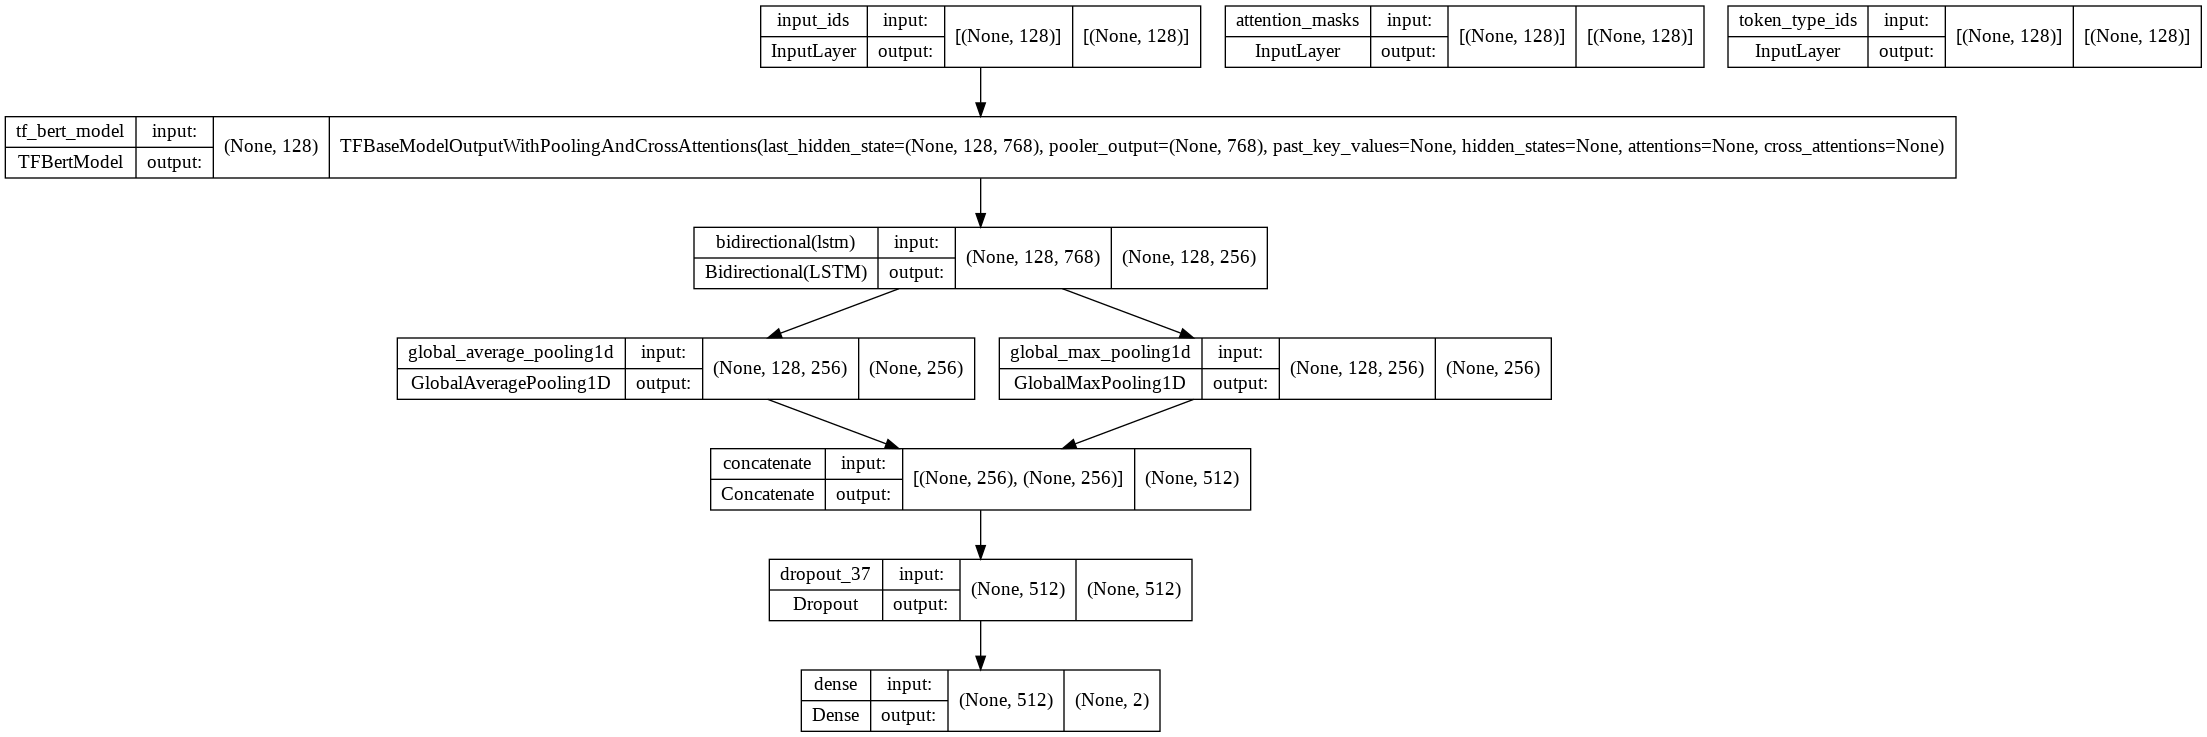

In [17]:
dot_img_file = '/tmp/model_1.png'

tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

Create train and validation data generators

In [33]:
train_data = BertSemanticDataGenerator(
    train_df[["sentence1", "sentence2"]].values.astype("str"),
    y_train,
    batch_size=batch_size,
    shuffle=True,
)
valid_data = BertSemanticDataGenerator(
    valid_df[["sentence1", "sentence2"]].values.astype("str"),
    y_val,
    batch_size=batch_size,
    shuffle=False,
)

## Train the Model

Training is done only for the top layers to perform "feature extraction",
which will allow the model to use the representations of the pretrained model.

In [34]:
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=epochs,
    use_multiprocessing=True,
    workers=-1,
)

 584/3125 [====>.........................] - ETA: 13:17 - loss: 0.2509 - acc: 0.8962

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 586/3125 [====>.........................] - ETA: 13:16 - loss: 0.2509 - acc: 0.8962

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 612/3125 [====>.........................] - ETA: 13:08 - loss: 0.2508 - acc: 0.8963

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 625/3125 [=====>........................] - ETA: 13:04 - loss: 0.2509 - acc: 0.8962

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 670/3125 [=====>........................] - ETA: 12:50 - loss: 0.2511 - acc: 0.8965

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 709/3125 [=====>........................] - ETA: 12:38 - loss: 0.2505 - acc: 0.8968

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 718/3125 [=====>........................] - ETA: 12:35 - loss: 0.2507 - acc: 0.8968

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 729/3125 [=====>........................] - ETA: 12:32 - loss: 0.2501 - acc: 0.8970

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 756/3125 [======>.......................] - ETA: 12:23 - loss: 0.2503 - acc: 0.8969

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 786/3125 [======>.......................] - ETA: 12:14 - loss: 0.2505 - acc: 0.8967

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 792/3125 [======>.......................] - ETA: 12:12 - loss: 0.2502 - acc: 0.8968

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 848/3125 [=======>......................] - ETA: 11:54 - loss: 0.2520 - acc: 0.8962

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 914/3125 [=======>......................] - ETA: 11:34 - loss: 0.2533 - acc: 0.8957

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 918/3125 [=======>......................] - ETA: 11:33 - loss: 0.2532 - acc: 0.8958

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 930/3125 [=======>......................] - ETA: 11:29 - loss: 0.2531 - acc: 0.8957

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 943/3125 [========>.....................] - ETA: 11:25 - loss: 0.2527 - acc: 0.8960

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 956/3125 [========>.....................] - ETA: 11:21 - loss: 0.2528 - acc: 0.8959

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 972/3125 [========>.....................] - ETA: 11:15 - loss: 0.2527 - acc: 0.8959

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 993/3125 [========>.....................] - ETA: 11:09 - loss: 0.2533 - acc: 0.8958

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 999/3125 [========>.....................] - ETA: 11:07 - loss: 0.2533 - acc: 0.8958

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1020/3125 [========>.....................] - ETA: 11:00 - loss: 0.2530 - acc: 0.8957

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1023/3125 [========>.....................] - ETA: 10:59 - loss: 0.2529 - acc: 0.8958

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1033/3125 [========>.....................] - ETA: 10:56 - loss: 0.2525 - acc: 0.8958

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1115/3125 [=========>....................] - ETA: 10:32 - loss: 0.2521 - acc: 0.8957

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1147/3125 [==========>...................] - ETA: 10:22 - loss: 0.2527 - acc: 0.8954

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1253/3125 [===========>..................] - ETA: 9:50 - loss: 0.2527 - acc: 0.8950

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1288/3125 [===========>..................] - ETA: 9:39 - loss: 0.2523 - acc: 0.8954

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1322/3125 [===========>..................] - ETA: 9:28 - loss: 0.2528 - acc: 0.8952

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1362/3125 [============>.................] - ETA: 9:16 - loss: 0.2534 - acc: 0.8947

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1399/3125 [============>.................] - ETA: 9:04 - loss: 0.2530 - acc: 0.8947

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1442/3125 [============>.................] - ETA: 8:51 - loss: 0.2535 - acc: 0.8947

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1504/3125 [=============>................] - ETA: 8:32 - loss: 0.2539 - acc: 0.8948

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1512/3125 [=============>................] - ETA: 8:29 - loss: 0.2538 - acc: 0.8948

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1619/3125 [==============>...............] - ETA: 7:56 - loss: 0.2547 - acc: 0.8947

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1649/3125 [==============>...............] - ETA: 7:46 - loss: 0.2542 - acc: 0.8949

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1662/3125 [==============>...............] - ETA: 7:42 - loss: 0.2543 - acc: 0.8949

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1767/3125 [===============>..............] - ETA: 7:09 - loss: 0.2538 - acc: 0.8951

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1783/3125 [================>.............] - ETA: 7:04 - loss: 0.2543 - acc: 0.8950

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1794/3125 [================>.............] - ETA: 7:01 - loss: 0.2541 - acc: 0.8951

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1810/3125 [================>.............] - ETA: 6:56 - loss: 0.2541 - acc: 0.8950

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1861/3125 [================>.............] - ETA: 6:40 - loss: 0.2545 - acc: 0.8947

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1888/3125 [=================>............] - ETA: 6:31 - loss: 0.2545 - acc: 0.8947

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1902/3125 [=================>............] - ETA: 6:27 - loss: 0.2545 - acc: 0.8947

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1941/3125 [=================>............] - ETA: 6:15 - loss: 0.2539 - acc: 0.8947

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1958/3125 [=================>............] - ETA: 6:09 - loss: 0.2538 - acc: 0.8948

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2013/3125 [==================>...........] - ETA: 5:52 - loss: 0.2536 - acc: 0.8950

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2065/3125 [==================>...........] - ETA: 5:36 - loss: 0.2533 - acc: 0.8953

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2109/3125 [===================>..........] - ETA: 5:22 - loss: 0.2529 - acc: 0.8954

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2118/3125 [===================>..........] - ETA: 5:19 - loss: 0.2530 - acc: 0.8954

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2185/3125 [===================>..........] - ETA: 4:58 - loss: 0.2533 - acc: 0.8953

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2193/3125 [====================>.........] - ETA: 4:55 - loss: 0.2535 - acc: 0.8953

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2203/3125 [====================>.........] - ETA: 4:52 - loss: 0.2533 - acc: 0.8954

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2240/3125 [====================>.........] - ETA: 4:40 - loss: 0.2534 - acc: 0.8953

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2291/3125 [====================>.........] - ETA: 4:24 - loss: 0.2533 - acc: 0.8954

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2434/3125 [======================>.......] - ETA: 3:39 - loss: 0.2533 - acc: 0.8956

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2537/3125 [=======================>......] - ETA: 3:06 - loss: 0.2534 - acc: 0.8956

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2560/3125 [=======================>......] - ETA: 2:59 - loss: 0.2534 - acc: 0.8955

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2566/3125 [=======================>......] - ETA: 2:57 - loss: 0.2533 - acc: 0.8956

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2606/3125 [========================>.....] - ETA: 2:44 - loss: 0.2533 - acc: 0.8958

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2628/3125 [========================>.....] - ETA: 2:37 - loss: 0.2531 - acc: 0.8959

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2653/3125 [========================>.....] - ETA: 2:29 - loss: 0.2531 - acc: 0.8959

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2710/3125 [=========================>....] - ETA: 2:11 - loss: 0.2535 - acc: 0.8957

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2763/3125 [=========================>....] - ETA: 1:55 - loss: 0.2534 - acc: 0.8958

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2784/3125 [=========================>....] - ETA: 1:48 - loss: 0.2531 - acc: 0.8959

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2792/3125 [=========================>....] - ETA: 1:45 - loss: 0.2531 - acc: 0.8959

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2823/3125 [==========================>...] - ETA: 1:35 - loss: 0.2528 - acc: 0.8961

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2855/3125 [==========================>...] - ETA: 1:25 - loss: 0.2527 - acc: 0.8961

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2859/3125 [==========================>...] - ETA: 1:24 - loss: 0.2527 - acc: 0.8961

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2868/3125 [==========================>...] - ETA: 1:21 - loss: 0.2528 - acc: 0.8961

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2877/3125 [==========================>...] - ETA: 1:18 - loss: 0.2528 - acc: 0.8961

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2988/3125 [===========================>..] - ETA: 43s - loss: 0.2521 - acc: 0.8963

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2993/3125 [===========================>..] - ETA: 41s - loss: 0.2520 - acc: 0.8963

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3015/3125 [===========================>..] - ETA: 34s - loss: 0.2521 - acc: 0.8964

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3073/3125 [============================>.] - ETA: 16s - loss: 0.2517 - acc: 0.8967

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3125/3125 [==============================] - ETA: 0s - loss: 0.2516 - acc: 0.8967

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3125/3125 [==============================] - 1053s 337ms/step - loss: 0.2516 - acc: 0.8967 - val_loss: 0.2060 - val_acc: 0.9191
Epoch 3/3
  11/3125 [..............................] - ETA: 16:35 - loss: 0.2278 - acc: 0.9261

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  30/3125 [..............................] - ETA: 16:39 - loss: 0.2376 - acc: 0.9083

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  86/3125 [..............................] - ETA: 16:14 - loss: 0.2392 - acc: 0.9030

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 107/3125 [>.............................] - ETA: 16:08 - loss: 0.2370 - acc: 0.9039

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 133/3125 [>.............................] - ETA: 15:59 - loss: 0.2359 - acc: 0.9058

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 159/3125 [>.............................] - ETA: 15:50 - loss: 0.2350 - acc: 0.9066

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 227/3125 [=>............................] - ETA: 15:28 - loss: 0.2380 - acc: 0.9054

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 241/3125 [=>............................] - ETA: 15:24 - loss: 0.2381 - acc: 0.9050

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 243/3125 [=>............................] - ETA: 15:23 - loss: 0.2377 - acc: 0.9051

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 266/3125 [=>............................] - ETA: 15:16 - loss: 0.2359 - acc: 0.9047

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 276/3125 [=>............................] - ETA: 15:13 - loss: 0.2354 - acc: 0.9048

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 292/3125 [=>............................] - ETA: 15:08 - loss: 0.2354 - acc: 0.9045

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 312/3125 [=>............................] - ETA: 15:02 - loss: 0.2333 - acc: 0.9049

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 324/3125 [==>...........................] - ETA: 14:59 - loss: 0.2327 - acc: 0.9049

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 330/3125 [==>...........................] - ETA: 14:57 - loss: 0.2326 - acc: 0.9049

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 338/3125 [==>...........................] - ETA: 14:54 - loss: 0.2322 - acc: 0.9048

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 343/3125 [==>...........................] - ETA: 14:53 - loss: 0.2313 - acc: 0.9052

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 345/3125 [==>...........................] - ETA: 14:52 - loss: 0.2310 - acc: 0.9055

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 348/3125 [==>...........................] - ETA: 14:51 - loss: 0.2308 - acc: 0.9054

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 377/3125 [==>...........................] - ETA: 14:41 - loss: 0.2309 - acc: 0.9059

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 414/3125 [==>...........................] - ETA: 14:29 - loss: 0.2325 - acc: 0.9056

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 449/3125 [===>..........................] - ETA: 14:18 - loss: 0.2309 - acc: 0.9064

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 454/3125 [===>..........................] - ETA: 14:16 - loss: 0.2317 - acc: 0.9062

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 500/3125 [===>..........................] - ETA: 14:01 - loss: 0.2341 - acc: 0.9056

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 553/3125 [====>.........................] - ETA: 13:44 - loss: 0.2352 - acc: 0.9052

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 572/3125 [====>.........................] - ETA: 13:38 - loss: 0.2353 - acc: 0.9044

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 575/3125 [====>.........................] - ETA: 13:37 - loss: 0.2349 - acc: 0.9047

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 633/3125 [=====>........................] - ETA: 13:19 - loss: 0.2350 - acc: 0.9043

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 645/3125 [=====>........................] - ETA: 13:15 - loss: 0.2348 - acc: 0.9043

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 670/3125 [=====>........................] - ETA: 13:07 - loss: 0.2340 - acc: 0.9042

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 687/3125 [=====>........................] - ETA: 13:01 - loss: 0.2336 - acc: 0.9044

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 725/3125 [=====>........................] - ETA: 12:49 - loss: 0.2342 - acc: 0.9040

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 769/3125 [======>.......................] - ETA: 12:35 - loss: 0.2346 - acc: 0.9037

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 782/3125 [======>.......................] - ETA: 12:31 - loss: 0.2345 - acc: 0.9037

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 792/3125 [======>.......................] - ETA: 12:28 - loss: 0.2341 - acc: 0.9038

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 856/3125 [=======>......................] - ETA: 12:07 - loss: 0.2351 - acc: 0.9033

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 921/3125 [=======>......................] - ETA: 11:46 - loss: 0.2357 - acc: 0.9029

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 923/3125 [=======>......................] - ETA: 11:46 - loss: 0.2355 - acc: 0.9029

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 973/3125 [========>.....................] - ETA: 11:29 - loss: 0.2351 - acc: 0.9032

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1100/3125 [=========>....................] - ETA: 10:48 - loss: 0.2368 - acc: 0.9024

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1185/3125 [==========>...................] - ETA: 10:20 - loss: 0.2367 - acc: 0.9028

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1213/3125 [==========>...................] - ETA: 10:11 - loss: 0.2373 - acc: 0.9024

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1231/3125 [==========>...................] - ETA: 10:05 - loss: 0.2368 - acc: 0.9027

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1282/3125 [===========>..................] - ETA: 9:49 - loss: 0.2356 - acc: 0.9036

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1389/3125 [============>.................] - ETA: 9:14 - loss: 0.2344 - acc: 0.9040

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1554/3125 [=============>................] - ETA: 8:21 - loss: 0.2360 - acc: 0.9037

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1558/3125 [=============>................] - ETA: 8:19 - loss: 0.2359 - acc: 0.9037

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1565/3125 [==============>...............] - ETA: 8:17 - loss: 0.2359 - acc: 0.9037

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1567/3125 [==============>...............] - ETA: 8:17 - loss: 0.2358 - acc: 0.9037

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1595/3125 [==============>...............] - ETA: 8:08 - loss: 0.2356 - acc: 0.9036

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1620/3125 [==============>...............] - ETA: 7:59 - loss: 0.2351 - acc: 0.9038

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1623/3125 [==============>...............] - ETA: 7:59 - loss: 0.2351 - acc: 0.9038

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1665/3125 [==============>...............] - ETA: 7:45 - loss: 0.2354 - acc: 0.9036

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1671/3125 [===============>..............] - ETA: 7:43 - loss: 0.2356 - acc: 0.9035

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1733/3125 [===============>..............] - ETA: 7:23 - loss: 0.2361 - acc: 0.9032

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1795/3125 [================>.............] - ETA: 7:03 - loss: 0.2367 - acc: 0.9029

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1845/3125 [================>.............] - ETA: 6:47 - loss: 0.2372 - acc: 0.9026

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1851/3125 [================>.............] - ETA: 6:45 - loss: 0.2371 - acc: 0.9027

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1897/3125 [=================>............] - ETA: 6:30 - loss: 0.2369 - acc: 0.9027

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1906/3125 [=================>............] - ETA: 6:28 - loss: 0.2370 - acc: 0.9028

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1951/3125 [=================>............] - ETA: 6:13 - loss: 0.2372 - acc: 0.9028

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2013/3125 [==================>...........] - ETA: 5:53 - loss: 0.2372 - acc: 0.9028

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2049/3125 [==================>...........] - ETA: 5:42 - loss: 0.2370 - acc: 0.9029

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2073/3125 [==================>...........] - ETA: 5:34 - loss: 0.2371 - acc: 0.9028

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2087/3125 [===================>..........] - ETA: 5:30 - loss: 0.2368 - acc: 0.9029

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2162/3125 [===================>..........] - ETA: 5:06 - loss: 0.2367 - acc: 0.9028

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2177/3125 [===================>..........] - ETA: 5:01 - loss: 0.2366 - acc: 0.9030

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2191/3125 [====================>.........] - ETA: 4:56 - loss: 0.2363 - acc: 0.9031

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2210/3125 [====================>.........] - ETA: 4:50 - loss: 0.2360 - acc: 0.9032

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2212/3125 [====================>.........] - ETA: 4:50 - loss: 0.2360 - acc: 0.9032

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2243/3125 [====================>.........] - ETA: 4:40 - loss: 0.2361 - acc: 0.9033

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2255/3125 [====================>.........] - ETA: 4:36 - loss: 0.2363 - acc: 0.9031

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2298/3125 [=====================>........] - ETA: 4:22 - loss: 0.2361 - acc: 0.9032

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2357/3125 [=====================>........] - ETA: 4:03 - loss: 0.2363 - acc: 0.9030

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2447/3125 [======================>.......] - ETA: 3:35 - loss: 0.2363 - acc: 0.9031

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2461/3125 [======================>.......] - ETA: 3:30 - loss: 0.2362 - acc: 0.9032

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2474/3125 [======================>.......] - ETA: 3:26 - loss: 0.2361 - acc: 0.9032

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2477/3125 [======================>.......] - ETA: 3:25 - loss: 0.2361 - acc: 0.9032

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2582/3125 [=======================>......] - ETA: 2:52 - loss: 0.2358 - acc: 0.9032

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2584/3125 [=======================>......] - ETA: 2:51 - loss: 0.2357 - acc: 0.9032

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2660/3125 [========================>.....] - ETA: 2:27 - loss: 0.2357 - acc: 0.9033

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2741/3125 [=========================>....] - ETA: 2:01 - loss: 0.2353 - acc: 0.9034

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2776/3125 [=========================>....] - ETA: 1:50 - loss: 0.2352 - acc: 0.9035

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2818/3125 [==========================>...] - ETA: 1:37 - loss: 0.2356 - acc: 0.9035

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2827/3125 [==========================>...] - ETA: 1:34 - loss: 0.2356 - acc: 0.9034

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2839/3125 [==========================>...] - ETA: 1:30 - loss: 0.2356 - acc: 0.9034

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2935/3125 [===========================>..] - ETA: 1:00 - loss: 0.2353 - acc: 0.9035

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2939/3125 [===========================>..] - ETA: 58s - loss: 0.2352 - acc: 0.9035

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2970/3125 [===========================>..] - ETA: 49s - loss: 0.2351 - acc: 0.9036

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2989/3125 [===========================>..] - ETA: 43s - loss: 0.2351 - acc: 0.9036

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3045/3125 [============================>.] - ETA: 25s - loss: 0.2350 - acc: 0.9037

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3050/3125 [============================>.] - ETA: 23s - loss: 0.2350 - acc: 0.9036

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3065/3125 [============================>.] - ETA: 19s - loss: 0.2348 - acc: 0.9037

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3125/3125 [==============================] - ETA: 0s - loss: 0.2345 - acc: 0.9039

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3125/3125 [==============================] - 1050s 336ms/step - loss: 0.2345 - acc: 0.9039 - val_loss: 0.1966 - val_acc: 0.9243


## Fine-tuning

This step must only be performed after the feature extraction model has
been trained to convergence on the new data.

This is an optional last step where `bert_model` is unfreezed and retrained
with a very low learning rate. This can deliver meaningful improvement by
incrementally adapting the pretrained features to the new data.

In [35]:
# Unfreeze the bert_model.
bert_model.trainable = True
# Recompile the model to make the change effective.
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"],

)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_masks[0][0]',  

# Train the entire model end-to-end.

In [36]:
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=epochs,
    use_multiprocessing=True,
    workers=-1,
)

Epoch 1/3
  20/3125 [..............................] - ETA: 41:56 - loss: 0.2420 - accuracy: 0.9047

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  52/3125 [..............................] - ETA: 42:13 - loss: 0.2007 - accuracy: 0.9183

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  55/3125 [..............................] - ETA: 42:14 - loss: 0.2027 - accuracy: 0.9176

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  83/3125 [..............................] - ETA: 41:57 - loss: 0.2093 - accuracy: 0.9168

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 180/3125 [>.............................] - ETA: 40:32 - loss: 0.2036 - accuracy: 0.9194

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 193/3125 [>.............................] - ETA: 40:21 - loss: 0.2052 - accuracy: 0.9190

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 195/3125 [>.............................] - ETA: 40:19 - loss: 0.2050 - accuracy: 0.9191

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 211/3125 [=>............................] - ETA: 40:05 - loss: 0.2038 - accuracy: 0.9200

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 304/3125 [=>............................] - ETA: 38:47 - loss: 0.2029 - accuracy: 0.9209

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 360/3125 [==>...........................] - ETA: 38:01 - loss: 0.1992 - accuracy: 0.9221

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 417/3125 [===>..........................] - ETA: 37:14 - loss: 0.1956 - accuracy: 0.9226

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 450/3125 [===>..........................] - ETA: 36:47 - loss: 0.1969 - accuracy: 0.9220

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 490/3125 [===>..........................] - ETA: 36:14 - loss: 0.1939 - accuracy: 0.9235

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 502/3125 [===>..........................] - ETA: 36:04 - loss: 0.1937 - accuracy: 0.9237

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 522/3125 [====>.........................] - ETA: 35:47 - loss: 0.1936 - accuracy: 0.9237

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 538/3125 [====>.........................] - ETA: 35:34 - loss: 0.1926 - accuracy: 0.9241

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 574/3125 [====>.........................] - ETA: 35:05 - loss: 0.1919 - accuracy: 0.9247

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 607/3125 [====>.........................] - ETA: 34:37 - loss: 0.1912 - accuracy: 0.9252

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 624/3125 [====>.........................] - ETA: 34:23 - loss: 0.1908 - accuracy: 0.9255

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 650/3125 [=====>........................] - ETA: 34:02 - loss: 0.1914 - accuracy: 0.9254

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 704/3125 [=====>........................] - ETA: 33:17 - loss: 0.1915 - accuracy: 0.9254

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 733/3125 [======>.......................] - ETA: 32:53 - loss: 0.1914 - accuracy: 0.9254

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 734/3125 [======>.......................] - ETA: 32:52 - loss: 0.1914 - accuracy: 0.9254

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 771/3125 [======>.......................] - ETA: 32:22 - loss: 0.1914 - accuracy: 0.9253

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 776/3125 [======>.......................] - ETA: 32:18 - loss: 0.1912 - accuracy: 0.9254

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 834/3125 [=======>......................] - ETA: 31:30 - loss: 0.1887 - accuracy: 0.9269

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 878/3125 [=======>......................] - ETA: 30:54 - loss: 0.1886 - accuracy: 0.9272

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 879/3125 [=======>......................] - ETA: 30:53 - loss: 0.1886 - accuracy: 0.9272

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 894/3125 [=======>......................] - ETA: 30:40 - loss: 0.1889 - accuracy: 0.9271

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 914/3125 [=======>......................] - ETA: 30:24 - loss: 0.1886 - accuracy: 0.9271

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 952/3125 [========>.....................] - ETA: 29:52 - loss: 0.1885 - accuracy: 0.9274

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1002/3125 [========>.....................] - ETA: 29:11 - loss: 0.1892 - accuracy: 0.9272

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1066/3125 [=========>....................] - ETA: 28:18 - loss: 0.1886 - accuracy: 0.9275

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1100/3125 [=========>....................] - ETA: 27:50 - loss: 0.1889 - accuracy: 0.9272

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1129/3125 [=========>....................] - ETA: 27:26 - loss: 0.1892 - accuracy: 0.9273

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1205/3125 [==========>...................] - ETA: 26:24 - loss: 0.1883 - accuracy: 0.9274

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1247/3125 [==========>...................] - ETA: 25:49 - loss: 0.1881 - accuracy: 0.9273

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1283/3125 [===========>..................] - ETA: 25:19 - loss: 0.1877 - accuracy: 0.9273

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1286/3125 [===========>..................] - ETA: 25:17 - loss: 0.1878 - accuracy: 0.9274

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1287/3125 [===========>..................] - ETA: 25:16 - loss: 0.1880 - accuracy: 0.9273

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1291/3125 [===========>..................] - ETA: 25:13 - loss: 0.1880 - accuracy: 0.9274

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1304/3125 [===========>..................] - ETA: 25:02 - loss: 0.1875 - accuracy: 0.9276

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1331/3125 [===========>..................] - ETA: 24:40 - loss: 0.1870 - accuracy: 0.9280

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1443/3125 [============>.................] - ETA: 23:07 - loss: 0.1868 - accuracy: 0.9278

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1448/3125 [============>.................] - ETA: 23:03 - loss: 0.1867 - accuracy: 0.9279

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1611/3125 [==============>...............] - ETA: 20:49 - loss: 0.1848 - accuracy: 0.9284

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1638/3125 [==============>...............] - ETA: 20:26 - loss: 0.1851 - accuracy: 0.9283

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1654/3125 [==============>...............] - ETA: 20:13 - loss: 0.1847 - accuracy: 0.9284

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1697/3125 [===============>..............] - ETA: 19:38 - loss: 0.1844 - accuracy: 0.9286

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1703/3125 [===============>..............] - ETA: 19:33 - loss: 0.1844 - accuracy: 0.9286

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1780/3125 [================>.............] - ETA: 18:29 - loss: 0.1837 - accuracy: 0.9290

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1794/3125 [================>.............] - ETA: 18:18 - loss: 0.1835 - accuracy: 0.9290

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1843/3125 [================>.............] - ETA: 17:37 - loss: 0.1831 - accuracy: 0.9294

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1847/3125 [================>.............] - ETA: 17:34 - loss: 0.1831 - accuracy: 0.9294

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1849/3125 [================>.............] - ETA: 17:32 - loss: 0.1830 - accuracy: 0.9294

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1859/3125 [================>.............] - ETA: 17:24 - loss: 0.1829 - accuracy: 0.9294

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1881/3125 [=================>............] - ETA: 17:06 - loss: 0.1827 - accuracy: 0.9295

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1900/3125 [=================>............] - ETA: 16:50 - loss: 0.1825 - accuracy: 0.9295

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1916/3125 [=================>............] - ETA: 16:37 - loss: 0.1822 - accuracy: 0.9296

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1921/3125 [=================>............] - ETA: 16:33 - loss: 0.1823 - accuracy: 0.9296

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1946/3125 [=================>............] - ETA: 16:12 - loss: 0.1824 - accuracy: 0.9296

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2032/3125 [==================>...........] - ETA: 15:01 - loss: 0.1811 - accuracy: 0.9302

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2049/3125 [==================>...........] - ETA: 14:47 - loss: 0.1808 - accuracy: 0.9304

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2079/3125 [==================>...........] - ETA: 14:23 - loss: 0.1806 - accuracy: 0.9304

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2117/3125 [===================>..........] - ETA: 13:51 - loss: 0.1808 - accuracy: 0.9302

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2146/3125 [===================>..........] - ETA: 13:27 - loss: 0.1804 - accuracy: 0.9304

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2246/3125 [====================>.........] - ETA: 12:05 - loss: 0.1793 - accuracy: 0.9310

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2247/3125 [====================>.........] - ETA: 12:04 - loss: 0.1793 - accuracy: 0.9310

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2264/3125 [====================>.........] - ETA: 11:50 - loss: 0.1790 - accuracy: 0.9310

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2270/3125 [====================>.........] - ETA: 11:45 - loss: 0.1790 - accuracy: 0.9310

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2274/3125 [====================>.........] - ETA: 11:42 - loss: 0.1789 - accuracy: 0.9310

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2282/3125 [====================>.........] - ETA: 11:35 - loss: 0.1788 - accuracy: 0.9311

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2290/3125 [====================>.........] - ETA: 11:28 - loss: 0.1787 - accuracy: 0.9311

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2292/3125 [=====================>........] - ETA: 11:27 - loss: 0.1788 - accuracy: 0.9311

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2329/3125 [=====================>........] - ETA: 10:56 - loss: 0.1786 - accuracy: 0.9311

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2383/3125 [=====================>........] - ETA: 10:12 - loss: 0.1779 - accuracy: 0.9313

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2401/3125 [======================>.......] - ETA: 9:57 - loss: 0.1774 - accuracy: 0.9315

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2404/3125 [======================>.......] - ETA: 9:54 - loss: 0.1774 - accuracy: 0.9315

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2430/3125 [======================>.......] - ETA: 9:33 - loss: 0.1771 - accuracy: 0.9317

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2502/3125 [=======================>......] - ETA: 8:34 - loss: 0.1765 - accuracy: 0.9319

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2512/3125 [=======================>......] - ETA: 8:25 - loss: 0.1765 - accuracy: 0.9319

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2584/3125 [=======================>......] - ETA: 7:26 - loss: 0.1758 - accuracy: 0.9322

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2586/3125 [=======================>......] - ETA: 7:24 - loss: 0.1757 - accuracy: 0.9322

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2691/3125 [========================>.....] - ETA: 5:58 - loss: 0.1746 - accuracy: 0.9328

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2822/3125 [==========================>...] - ETA: 4:09 - loss: 0.1726 - accuracy: 0.9338

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2824/3125 [==========================>...] - ETA: 4:08 - loss: 0.1725 - accuracy: 0.9338

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2853/3125 [==========================>...] - ETA: 3:44 - loss: 0.1723 - accuracy: 0.9338

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2860/3125 [==========================>...] - ETA: 3:38 - loss: 0.1723 - accuracy: 0.9337

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2925/3125 [===========================>..] - ETA: 2:45 - loss: 0.1719 - accuracy: 0.9340

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2975/3125 [===========================>..] - ETA: 2:03 - loss: 0.1717 - accuracy: 0.9341

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2977/3125 [===========================>..] - ETA: 2:02 - loss: 0.1717 - accuracy: 0.9341

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2985/3125 [===========================>..] - ETA: 1:55 - loss: 0.1718 - accuracy: 0.9341

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3077/3125 [============================>.] - ETA: 39s - loss: 0.1711 - accuracy: 0.9344

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3125/3125 [==============================] - ETA: 0s - loss: 0.1708 - accuracy: 0.9346

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3125/3125 [==============================] - 2661s 845ms/step - loss: 0.1708 - accuracy: 0.9346 - val_loss: 0.1296 - val_accuracy: 0.9528
Epoch 2/3
   8/3125 [..............................] - ETA: 42:43 - loss: 0.1343 - accuracy: 0.9414

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  53/3125 [..............................] - ETA: 42:10 - loss: 0.1103 - accuracy: 0.9640

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  87/3125 [..............................] - ETA: 41:42 - loss: 0.1030 - accuracy: 0.9644

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 141/3125 [>.............................] - ETA: 40:58 - loss: 0.1009 - accuracy: 0.9625

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 224/3125 [=>............................] - ETA: 39:52 - loss: 0.1038 - accuracy: 0.9628

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 254/3125 [=>............................] - ETA: 39:27 - loss: 0.1060 - accuracy: 0.9615

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 359/3125 [==>...........................] - ETA: 38:00 - loss: 0.1028 - accuracy: 0.9621

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 381/3125 [==>...........................] - ETA: 37:42 - loss: 0.1018 - accuracy: 0.9624

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 440/3125 [===>..........................] - ETA: 36:53 - loss: 0.1029 - accuracy: 0.9619

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 455/3125 [===>..........................] - ETA: 36:41 - loss: 0.1032 - accuracy: 0.9617

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 513/3125 [===>..........................] - ETA: 35:53 - loss: 0.1039 - accuracy: 0.9615

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 553/3125 [====>.........................] - ETA: 35:20 - loss: 0.1032 - accuracy: 0.9620

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 561/3125 [====>.........................] - ETA: 35:14 - loss: 0.1032 - accuracy: 0.9620

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 575/3125 [====>.........................] - ETA: 35:02 - loss: 0.1032 - accuracy: 0.9622

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 579/3125 [====>.........................] - ETA: 34:59 - loss: 0.1030 - accuracy: 0.9623

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 723/3125 [=====>........................] - ETA: 33:00 - loss: 0.1006 - accuracy: 0.9625

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 727/3125 [=====>........................] - ETA: 32:57 - loss: 0.1009 - accuracy: 0.9623

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 822/3125 [======>.......................] - ETA: 31:39 - loss: 0.1005 - accuracy: 0.9627

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 825/3125 [======>.......................] - ETA: 31:36 - loss: 0.1005 - accuracy: 0.9627

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 840/3125 [=======>......................] - ETA: 31:24 - loss: 0.1000 - accuracy: 0.9629

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 853/3125 [=======>......................] - ETA: 31:13 - loss: 0.0997 - accuracy: 0.9630

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 898/3125 [=======>......................] - ETA: 30:36 - loss: 0.1002 - accuracy: 0.9628

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 971/3125 [========>.....................] - ETA: 29:36 - loss: 0.0996 - accuracy: 0.9629

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1002/3125 [========>.....................] - ETA: 29:11 - loss: 0.1000 - accuracy: 0.9629

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1004/3125 [========>.....................] - ETA: 29:09 - loss: 0.0999 - accuracy: 0.9629

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1032/3125 [========>.....................] - ETA: 28:46 - loss: 0.1001 - accuracy: 0.9628

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1034/3125 [========>.....................] - ETA: 28:44 - loss: 0.1002 - accuracy: 0.9628

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1069/3125 [=========>....................] - ETA: 28:15 - loss: 0.1003 - accuracy: 0.9627

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1073/3125 [=========>....................] - ETA: 28:12 - loss: 0.1007 - accuracy: 0.9626

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1083/3125 [=========>....................] - ETA: 28:04 - loss: 0.1008 - accuracy: 0.9624

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1124/3125 [=========>....................] - ETA: 27:30 - loss: 0.1004 - accuracy: 0.9626

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1168/3125 [==========>...................] - ETA: 26:54 - loss: 0.0999 - accuracy: 0.9628

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1180/3125 [==========>...................] - ETA: 26:44 - loss: 0.1001 - accuracy: 0.9627

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1189/3125 [==========>...................] - ETA: 26:37 - loss: 0.1000 - accuracy: 0.9628

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1192/3125 [==========>...................] - ETA: 26:34 - loss: 0.1000 - accuracy: 0.9628

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1217/3125 [==========>...................] - ETA: 26:13 - loss: 0.1002 - accuracy: 0.9627

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1266/3125 [===========>..................] - ETA: 25:33 - loss: 0.1000 - accuracy: 0.9630

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1271/3125 [===========>..................] - ETA: 25:29 - loss: 0.0998 - accuracy: 0.9630

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1275/3125 [===========>..................] - ETA: 25:26 - loss: 0.1003 - accuracy: 0.9629

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1398/3125 [============>.................] - ETA: 23:44 - loss: 0.1003 - accuracy: 0.9629

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1418/3125 [============>.................] - ETA: 23:28 - loss: 0.0999 - accuracy: 0.9631

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1449/3125 [============>.................] - ETA: 23:02 - loss: 0.1001 - accuracy: 0.9631

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1456/3125 [============>.................] - ETA: 22:56 - loss: 0.1000 - accuracy: 0.9630

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1460/3125 [=============>................] - ETA: 22:53 - loss: 0.0999 - accuracy: 0.9631

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1461/3125 [=============>................] - ETA: 22:52 - loss: 0.1000 - accuracy: 0.9631

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1476/3125 [=============>................] - ETA: 22:40 - loss: 0.1000 - accuracy: 0.9630

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1486/3125 [=============>................] - ETA: 22:32 - loss: 0.1000 - accuracy: 0.9630

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1491/3125 [=============>................] - ETA: 22:28 - loss: 0.1000 - accuracy: 0.9630

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1526/3125 [=============>................] - ETA: 21:59 - loss: 0.1001 - accuracy: 0.9630

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1546/3125 [=============>................] - ETA: 21:42 - loss: 0.1002 - accuracy: 0.9630

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1568/3125 [==============>...............] - ETA: 21:24 - loss: 0.1001 - accuracy: 0.9631

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1587/3125 [==============>...............] - ETA: 21:08 - loss: 0.1004 - accuracy: 0.9630

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1632/3125 [==============>...............] - ETA: 20:31 - loss: 0.1005 - accuracy: 0.9630

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1637/3125 [==============>...............] - ETA: 20:27 - loss: 0.1006 - accuracy: 0.9629

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1677/3125 [===============>..............] - ETA: 19:54 - loss: 0.1002 - accuracy: 0.9630

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1713/3125 [===============>..............] - ETA: 19:24 - loss: 0.1004 - accuracy: 0.9630

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1734/3125 [===============>..............] - ETA: 19:07 - loss: 0.1005 - accuracy: 0.9629

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1747/3125 [===============>..............] - ETA: 18:56 - loss: 0.1005 - accuracy: 0.9629

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1774/3125 [================>.............] - ETA: 18:34 - loss: 0.1004 - accuracy: 0.9630

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1777/3125 [================>.............] - ETA: 18:32 - loss: 0.1005 - accuracy: 0.9629

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1781/3125 [================>.............] - ETA: 18:28 - loss: 0.1006 - accuracy: 0.9629

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1855/3125 [================>.............] - ETA: 17:27 - loss: 0.1013 - accuracy: 0.9627

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1928/3125 [=================>............] - ETA: 16:27 - loss: 0.1010 - accuracy: 0.9629

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1929/3125 [=================>............] - ETA: 16:26 - loss: 0.1010 - accuracy: 0.9628

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1947/3125 [=================>............] - ETA: 16:11 - loss: 0.1009 - accuracy: 0.9629

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1950/3125 [=================>............] - ETA: 16:09 - loss: 0.1009 - accuracy: 0.9629

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2028/3125 [==================>...........] - ETA: 15:05 - loss: 0.1003 - accuracy: 0.9630

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2052/3125 [==================>...........] - ETA: 14:45 - loss: 0.1004 - accuracy: 0.9629

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2111/3125 [===================>..........] - ETA: 13:56 - loss: 0.1009 - accuracy: 0.9628

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2227/3125 [====================>.........] - ETA: 12:20 - loss: 0.1004 - accuracy: 0.9631

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2276/3125 [====================>.........] - ETA: 11:40 - loss: 0.1007 - accuracy: 0.9630

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2296/3125 [=====================>........] - ETA: 11:23 - loss: 0.1009 - accuracy: 0.9630

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2311/3125 [=====================>........] - ETA: 11:11 - loss: 0.1010 - accuracy: 0.9629

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2342/3125 [=====================>........] - ETA: 10:45 - loss: 0.1010 - accuracy: 0.9630

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2421/3125 [======================>.......] - ETA: 9:40 - loss: 0.1016 - accuracy: 0.9626

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2458/3125 [======================>.......] - ETA: 9:10 - loss: 0.1015 - accuracy: 0.9627

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2472/3125 [======================>.......] - ETA: 8:58 - loss: 0.1015 - accuracy: 0.9627

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2495/3125 [======================>.......] - ETA: 8:39 - loss: 0.1014 - accuracy: 0.9627

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2514/3125 [=======================>......] - ETA: 8:24 - loss: 0.1015 - accuracy: 0.9627

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2528/3125 [=======================>......] - ETA: 8:12 - loss: 0.1014 - accuracy: 0.9627

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2557/3125 [=======================>......] - ETA: 7:48 - loss: 0.1016 - accuracy: 0.9628

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2579/3125 [=======================>......] - ETA: 7:30 - loss: 0.1017 - accuracy: 0.9627

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2605/3125 [========================>.....] - ETA: 7:09 - loss: 0.1018 - accuracy: 0.9627

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2627/3125 [========================>.....] - ETA: 6:50 - loss: 0.1018 - accuracy: 0.9627

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2650/3125 [========================>.....] - ETA: 6:31 - loss: 0.1017 - accuracy: 0.9628

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2707/3125 [========================>.....] - ETA: 5:44 - loss: 0.1016 - accuracy: 0.9628

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2785/3125 [=========================>....] - ETA: 4:40 - loss: 0.1015 - accuracy: 0.9629

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2804/3125 [=========================>....] - ETA: 4:24 - loss: 0.1014 - accuracy: 0.9629

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2859/3125 [==========================>...] - ETA: 3:39 - loss: 0.1012 - accuracy: 0.9631

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3065/3125 [============================>.] - ETA: 49s - loss: 0.1012 - accuracy: 0.9631

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3075/3125 [============================>.] - ETA: 41s - loss: 0.1012 - accuracy: 0.9631

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3096/3125 [============================>.] - ETA: 23s - loss: 0.1012 - accuracy: 0.9631

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3125/3125 [==============================] - ETA: 0s - loss: 0.1012 - accuracy: 0.9631

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3125/3125 [==============================] - 2637s 844ms/step - loss: 0.1012 - accuracy: 0.9631 - val_loss: 0.1171 - val_accuracy: 0.9575
Epoch 3/3
  31/3125 [..............................] - ETA: 42:35 - loss: 0.0790 - accuracy: 0.9748

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  81/3125 [..............................] - ETA: 41:54 - loss: 0.0731 - accuracy: 0.9753

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 116/3125 [>.............................] - ETA: 41:25 - loss: 0.0708 - accuracy: 0.9768

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 165/3125 [>.............................] - ETA: 40:45 - loss: 0.0689 - accuracy: 0.9777

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 248/3125 [=>............................] - ETA: 39:34 - loss: 0.0651 - accuracy: 0.9783

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 261/3125 [=>............................] - ETA: 39:23 - loss: 0.0667 - accuracy: 0.9778

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 278/3125 [=>............................] - ETA: 39:09 - loss: 0.0670 - accuracy: 0.9776

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 315/3125 [==>...........................] - ETA: 38:38 - loss: 0.0680 - accuracy: 0.9772

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 335/3125 [==>...........................] - ETA: 38:22 - loss: 0.0664 - accuracy: 0.9776

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 361/3125 [==>...........................] - ETA: 38:00 - loss: 0.0643 - accuracy: 0.9781

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 409/3125 [==>...........................] - ETA: 37:21 - loss: 0.0640 - accuracy: 0.9781

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 413/3125 [==>...........................] - ETA: 37:18 - loss: 0.0641 - accuracy: 0.9781

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 452/3125 [===>..........................] - ETA: 36:46 - loss: 0.0634 - accuracy: 0.9784

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 501/3125 [===>..........................] - ETA: 36:05 - loss: 0.0645 - accuracy: 0.9778

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 510/3125 [===>..........................] - ETA: 35:57 - loss: 0.0644 - accuracy: 0.9779

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 594/3125 [====>.........................] - ETA: 34:48 - loss: 0.0646 - accuracy: 0.9779

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 674/3125 [=====>........................] - ETA: 33:42 - loss: 0.0644 - accuracy: 0.9780

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 718/3125 [=====>........................] - ETA: 33:06 - loss: 0.0639 - accuracy: 0.9783

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 798/3125 [======>.......................] - ETA: 32:00 - loss: 0.0643 - accuracy: 0.9782

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 803/3125 [======>.......................] - ETA: 31:56 - loss: 0.0641 - accuracy: 0.9782

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 823/3125 [======>.......................] - ETA: 31:39 - loss: 0.0637 - accuracy: 0.9784

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 839/3125 [=======>......................] - ETA: 31:26 - loss: 0.0637 - accuracy: 0.9784

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 918/3125 [=======>......................] - ETA: 30:21 - loss: 0.0636 - accuracy: 0.9783

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1022/3125 [========>.....................] - ETA: 28:55 - loss: 0.0619 - accuracy: 0.9787

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1028/3125 [========>.....................] - ETA: 28:50 - loss: 0.0618 - accuracy: 0.9788

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1051/3125 [=========>....................] - ETA: 28:31 - loss: 0.0619 - accuracy: 0.9787

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1076/3125 [=========>....................] - ETA: 28:10 - loss: 0.0620 - accuracy: 0.9787

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1145/3125 [=========>....................] - ETA: 27:13 - loss: 0.0622 - accuracy: 0.9786

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1181/3125 [==========>...................] - ETA: 26:44 - loss: 0.0622 - accuracy: 0.9786

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1207/3125 [==========>...................] - ETA: 26:22 - loss: 0.0619 - accuracy: 0.9787

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1210/3125 [==========>...................] - ETA: 26:20 - loss: 0.0618 - accuracy: 0.9787

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1213/3125 [==========>...................] - ETA: 26:17 - loss: 0.0619 - accuracy: 0.9787

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1223/3125 [==========>...................] - ETA: 26:09 - loss: 0.0618 - accuracy: 0.9787

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1272/3125 [===========>..................] - ETA: 25:28 - loss: 0.0622 - accuracy: 0.9785

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1276/3125 [===========>..................] - ETA: 25:25 - loss: 0.0623 - accuracy: 0.9784

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1302/3125 [===========>..................] - ETA: 25:04 - loss: 0.0623 - accuracy: 0.9784

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1317/3125 [===========>..................] - ETA: 24:51 - loss: 0.0620 - accuracy: 0.9785

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1335/3125 [===========>..................] - ETA: 24:36 - loss: 0.0618 - accuracy: 0.9786

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1369/3125 [============>.................] - ETA: 24:08 - loss: 0.0615 - accuracy: 0.9787

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1442/3125 [============>.................] - ETA: 23:08 - loss: 0.0616 - accuracy: 0.9787

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1468/3125 [=============>................] - ETA: 22:47 - loss: 0.0617 - accuracy: 0.9788

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1471/3125 [=============>................] - ETA: 22:44 - loss: 0.0616 - accuracy: 0.9788

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1476/3125 [=============>................] - ETA: 22:40 - loss: 0.0616 - accuracy: 0.9788

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1504/3125 [=============>................] - ETA: 22:17 - loss: 0.0613 - accuracy: 0.9789

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1524/3125 [=============>................] - ETA: 22:00 - loss: 0.0613 - accuracy: 0.9788

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1538/3125 [=============>................] - ETA: 21:49 - loss: 0.0613 - accuracy: 0.9788

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1539/3125 [=============>................] - ETA: 21:48 - loss: 0.0613 - accuracy: 0.9788

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1645/3125 [==============>...............] - ETA: 20:21 - loss: 0.0614 - accuracy: 0.9786

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1702/3125 [===============>..............] - ETA: 19:34 - loss: 0.0616 - accuracy: 0.9786

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1720/3125 [===============>..............] - ETA: 19:19 - loss: 0.0616 - accuracy: 0.9786

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1784/3125 [================>.............] - ETA: 18:26 - loss: 0.0624 - accuracy: 0.9782

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1819/3125 [================>.............] - ETA: 17:57 - loss: 0.0626 - accuracy: 0.9783

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1892/3125 [=================>............] - ETA: 16:57 - loss: 0.0628 - accuracy: 0.9781

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1916/3125 [=================>............] - ETA: 16:37 - loss: 0.0629 - accuracy: 0.9781

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1949/3125 [=================>............] - ETA: 16:10 - loss: 0.0626 - accuracy: 0.9781

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1966/3125 [=================>............] - ETA: 15:56 - loss: 0.0628 - accuracy: 0.9781

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2014/3125 [==================>...........] - ETA: 15:16 - loss: 0.0633 - accuracy: 0.9779

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2032/3125 [==================>...........] - ETA: 15:01 - loss: 0.0632 - accuracy: 0.9780

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2035/3125 [==================>...........] - ETA: 14:59 - loss: 0.0631 - accuracy: 0.9780

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2070/3125 [==================>...........] - ETA: 14:30 - loss: 0.0636 - accuracy: 0.9779

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2119/3125 [===================>..........] - ETA: 13:50 - loss: 0.0636 - accuracy: 0.9778

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2136/3125 [===================>..........] - ETA: 13:36 - loss: 0.0636 - accuracy: 0.9778

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2242/3125 [====================>.........] - ETA: 12:08 - loss: 0.0635 - accuracy: 0.9778

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2245/3125 [====================>.........] - ETA: 12:06 - loss: 0.0636 - accuracy: 0.9778

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2252/3125 [====================>.........] - ETA: 12:00 - loss: 0.0636 - accuracy: 0.9778

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2329/3125 [=====================>........] - ETA: 10:56 - loss: 0.0635 - accuracy: 0.9778

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2366/3125 [=====================>........] - ETA: 10:26 - loss: 0.0633 - accuracy: 0.9779

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2386/3125 [=====================>........] - ETA: 10:09 - loss: 0.0632 - accuracy: 0.9779

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2442/3125 [======================>.......] - ETA: 9:23 - loss: 0.0629 - accuracy: 0.9779

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2453/3125 [======================>.......] - ETA: 9:14 - loss: 0.0628 - accuracy: 0.9780

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2503/3125 [=======================>......] - ETA: 8:33 - loss: 0.0626 - accuracy: 0.9780

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2508/3125 [=======================>......] - ETA: 8:29 - loss: 0.0626 - accuracy: 0.9780

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2530/3125 [=======================>......] - ETA: 8:11 - loss: 0.0625 - accuracy: 0.9780

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2536/3125 [=======================>......] - ETA: 8:06 - loss: 0.0627 - accuracy: 0.9780

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2561/3125 [=======================>......] - ETA: 7:45 - loss: 0.0629 - accuracy: 0.9779

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2588/3125 [=======================>......] - ETA: 7:23 - loss: 0.0628 - accuracy: 0.9780

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2614/3125 [========================>.....] - ETA: 7:01 - loss: 0.0628 - accuracy: 0.9780

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2644/3125 [========================>.....] - ETA: 6:36 - loss: 0.0628 - accuracy: 0.9779

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2661/3125 [========================>.....] - ETA: 6:22 - loss: 0.0629 - accuracy: 0.9779

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2675/3125 [========================>.....] - ETA: 6:11 - loss: 0.0627 - accuracy: 0.9780

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2748/3125 [=========================>....] - ETA: 5:11 - loss: 0.0629 - accuracy: 0.9779

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2776/3125 [=========================>....] - ETA: 4:48 - loss: 0.0628 - accuracy: 0.9779

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2783/3125 [=========================>....] - ETA: 4:42 - loss: 0.0628 - accuracy: 0.9780

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2831/3125 [==========================>...] - ETA: 4:02 - loss: 0.0627 - accuracy: 0.9780

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2865/3125 [==========================>...] - ETA: 3:34 - loss: 0.0628 - accuracy: 0.9780

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2959/3125 [===========================>..] - ETA: 2:17 - loss: 0.0631 - accuracy: 0.9779

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3002/3125 [===========================>..] - ETA: 1:41 - loss: 0.0632 - accuracy: 0.9778

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3009/3125 [===========================>..] - ETA: 1:35 - loss: 0.0632 - accuracy: 0.9778

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3046/3125 [============================>.] - ETA: 1:05 - loss: 0.0633 - accuracy: 0.9778

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3048/3125 [============================>.] - ETA: 1:03 - loss: 0.0632 - accuracy: 0.9779

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3072/3125 [============================>.] - ETA: 43s - loss: 0.0635 - accuracy: 0.9778

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3091/3125 [============================>.] - ETA: 28s - loss: 0.0635 - accuracy: 0.9778

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3107/3125 [============================>.] - ETA: 14s - loss: 0.0634 - accuracy: 0.9779

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3125/3125 [==============================] - ETA: 0s - loss: 0.0635 - accuracy: 0.9779

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3125/3125 [==============================] - 2639s 844ms/step - loss: 0.0635 - accuracy: 0.9779 - val_loss: 0.1307 - val_accuracy: 0.9569


## Evaluate model on the test set

In [ ]:
test_data = BertSemanticDataGenerator(
    test_df[["sentence1", "sentence2"]].values.astype("str"),
    y_test,
    batch_size=batch_size,
    shuffle=False,
)
model.evaluate(test_data, verbose=1)

## Inference on custom sentences

In [37]:

def check_similarity(sentence1, sentence2):
    sentence_pairs = np.array([[str(sentence1), str(sentence2)]])
    test_data = BertSemanticDataGenerator(
        sentence_pairs, labels=None, batch_size=1, shuffle=False, include_targets=False,
    )

    proba = model.predict(test_data[0])[0]
    
    idx = proba[1]
    proba = f"{idx: .2f}%"
    return  proba


Check results on some example sentence pairs.

In [58]:
sentence1 = "Two women are observing something together."
sentence2 = "Two women are standing with their eyes closed."
check_similarity(sentence1, sentence2)

' 0.00%'

Check results on some example sentence pairs.

In [59]:
sentence1 = "A smiling costumed woman is holding an umbrella"
sentence2 = "A happy woman in a fairy costume holds an umbrella"
check_similarity(sentence1, sentence2)

' 0.00%'

Check results on some example sentence pairs

In [60]:
sentence1 = "A soccer game with multiple males playing"
sentence2 = "Some men are playing a sport"
check_similarity(sentence1, sentence2)

' 1.00%'

In [66]:
sentence1 = "How old are you "
sentence2 = "What is your age"
check_similarity(sentence1, sentence2)

hello there


' 0.97%'

In [63]:
sentence1 = "मेरो नाम राम हो "
sentence2 = "म भरतपुर मा बस्छु   "
check_similarity(sentence1, sentence2)

' 0.04%'

In [64]:
sentence1 = "my name is bharat "
sentence2 = "my name is not bharat "
check_similarity(sentence1, sentence2)

' 0.01%'

In [43]:
question1=[]
question2=[]
question1 = ['Where do you live',
              'Where are you living',
              'What is your age',
              'Who is the president of USA',
             'Which age is the best age to what get married?',
              'How do I overcome my shyness with women?',
              'Should Harry Potter have ended up with Cho Chang?',
              'Where do macadamia nuts cost from?',
              'Who is the nicest person you have ever met?',
              'In do you say "closet" in French?',
             'what is your mobile number',
             'my company is apple',
             'i like apple',
             'i like apple',
            ]

question2 =['Where are you living',
             'what are you doing',
             'How old are you',
             'Name the current president of USA',
             'What is the best age to get for a woman?',
             'How do you overcome being shy?',
             'How powerful will Harry Potter become when he is grown up?',
             'What the hangouts courses offered at AIIMS Bhopal?',
             'Who was the weirdest classmate that you’ve ever met?',
             'In French, how do get you say "cool"',
            'which mobile number is you used',
            'I work in apple',
            'I work in apple',
            'my favourite fruit is apple', 
            ]

a1 = ['what is your mobile number?',
'Which model of mobile do you use?',
'Have you taken your dinner',
'who is the PM of Nepal',
'what is CPU',
'what type of coffee do you prefer',
'Who is barbari',
'Name of the main character of the Ramayan',
'which ISP do you use',
      'How old are you',
      'how old are you'
]


a2 = ['which mobile number is you used',
      'what is your mobiles model',
      'what meal do you eat at your dinner',
      'Name of the current PM of Nepal',
      'define CPU',
      'Which Coffee do you prefer to drink',
      'Name of the strongest character of Mahabharat',
      'Who is the main character of Ramayan',
      'which internet service provider do you use',
      'how good are you',
      'how age are you'
      ]

question1+=a1
question2+=a2


In [44]:
scores=[]
print(len(question1))
for i in range(len(question1)):
    scores.append(check_similarity(question1[i], question2[i]))

25


In [45]:
for i in range(len(scores)):
    print(question1[i]," || ",question2[i]," -->>  ",scores[i])

Where do you live  ||  Where are you living  -->>    0.97%
Where are you living  ||  what are you doing  -->>    0.52%
What is your age  ||  How old are you  -->>    0.95%
Who is the president of USA  ||  Name the current president of USA  -->>    0.82%
Which age is the best age to what get married?  ||  What is the best age to get for a woman?  -->>    0.71%
How do I overcome my shyness with women?  ||  How do you overcome being shy?  -->>    0.93%
Should Harry Potter have ended up with Cho Chang?  ||  How powerful will Harry Potter become when he is grown up?  -->>    0.29%
Where do macadamia nuts cost from?  ||  What the hangouts courses offered at AIIMS Bhopal?  -->>    0.01%
Who is the nicest person you have ever met?  ||  Who was the weirdest classmate that you’ve ever met?  -->>    0.20%
In do you say "closet" in French?  ||  In French, how do get you say "cool"  -->>    0.86%
what is your mobile number  ||  which mobile number is you used  -->>    0.85%
my company is apple  || 

In [ ]:
# import warnings
# warnings.filterwarnings('ignore')

In [ ]:
# pip freeze > colab_requirements.txt


In [ ]:
stop here

In [ ]:
arr=[]
for i in range(len(question1)):
  arr.append([question1[i],question2[i]])
arr= np.array(arr)

In [ ]:
batch_size=len(df)
test_data = BertSemanticDataGenerator(
            df[["question1", "question2"]].values.astype("str"),
            labels=None, batch_size=batch_size, shuffle=False, include_targets=False,
    )
# model.predict_on_batch(test_data)


In [ ]:
model.predict_on_batch(test_data[0])


In [ ]:
def create_model():
     # Encoded token ids from BERT tokenizer.
    input_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="input_ids"
    )
    # Attention masks indicates to the model which tokens should be attended to.
    attention_masks = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="attention_masks"
    )
    # Token type ids are binary masks identifying different sequences in the model.
    token_type_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="token_type_ids"
    )
    # Loading pretrained BERT model.
    bert_model = transformers.TFBertModel.from_pretrained("bert-base-uncased")
    # Freeze the BERT model to reuse the pretrained features without modifying them.
    bert_model.trainable = False

    bert_output = bert_model(
        input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids
    )
    sequence_output = bert_output.last_hidden_state
    pooled_output = bert_output.pooler_output
    # Add trainable layers on top of frozen layers to adapt the pretrained features on the new data.
    bi_lstm = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64, return_sequences=True)
    )(sequence_output)
    # Applying hybrid pooling approach to bi_lstm sequence output.
    # avg_pool = tf.keras.layers.GlobalAveragePooling1D()(bi_lstm)
    max_pool = tf.keras.layers.GlobalMaxPooling1D()(bi_lstm)
    # concat = tf.keras.layers.concatenate([avg_pool, max_pool])
    dropout = tf.keras.layers.Dropout(0.3)(max_pool)
    output = tf.keras.layers.Dense(2, activation="softmax")(dropout)
    model = tf.keras.models.Model(
        inputs=[input_ids, attention_masks, token_type_ids], outputs=output
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss="categorical_crossentropy",
        metrics=["acc"],
    )
    return model


In [46]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [48]:
model.save_weights('/content/drive/MyDrive/DATASETS/july17/')

In [ ]:
# model11= create_model()
# model11.load_weights('/content/h/')

In [51]:
bb=transformers.TFBertModel.from_pretrained('bert-base-uncased',cache_dir=None)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [50]:
bb

In [54]:
mm= create_model()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [56]:
mm.load_weights('/content/drive/MyDrive/DATASETS/july17/')

In [65]:

def check_similarity(sentence1, sentence2):
    sentence_pairs = np.array([[str(sentence1), str(sentence2)]])
    test_data = BertSemanticDataGenerator(
        sentence_pairs, labels=None, batch_size=1, shuffle=False, include_targets=False,
    )

    proba = mm.predict(test_data[0])[0]
    print('hello there')
    idx = proba[1]
    proba = f"{idx: .2f}%"
    return  proba
